# Fitting remaining ion current conductances

Using full AP/CaT measures to fit the remaining conductances.

# Imports

In [1]:
# PyABC imports
from pyabc import (ABCSMC, Distribution, RV,
                   History, MedianEpsilon)
from pyabc.populationstrategy import AdaptivePopulationSize
from pyabc.epsilon import MedianEpsilon
from pyabc.sampler import MulticoreEvalParallelSampler

In [2]:
# Custom imports
from ionchannelABC import (ion_channel_sum_stats_calculator,
                           IonChannelAcceptor,
                           IonChannelDistance,
                           EfficientMultivariateNormalTransition,
                           plot_parameter_sensitivity,
                           plot_parameters_kde,
                           plot_distance_weights)

INFO:myokit:Loading Myokit version 1.27.4


In [3]:
# Other necessary imports
import numpy as np
import subprocess
import pandas as pd
import io
import os
import tempfile

In [4]:
# Plotting imports
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config Inline.Backend.figure_format = 'retina'

# Generate samples of ABC channel results

In [5]:
history = {'icat': History('sqlite:///results/icat/hl-1_icat.db'),
           'ical': History('sqlite:///results/ical/hl-1_ical.db'),
           'ina': History('sqlite:///results/ina/hl-1_ina.db'),
           'ikr': History('sqlite:///results/ikr/hl-1_ikr.db'),
           'ikur': History('sqlite:///results/ikur/hl-1_ikur.db'),
           'ito': History('sqlite:///results/ito/hl-1_ito.db'),
           'iha': History('sqlite:///results/iha/hl-1_iha.db'),
           'ik1': History('sqlite:///results/ik1/hl-1_ik1.db')}

In [6]:
# Set to correct result (last ABC run in database).
for _,h in history.items():
    h.id = len(h.all_runs())

In [9]:
from pyabc.transition import MultivariateNormalTransition
class rv_normal_fit(MultivariateNormalTransition):
    def __init__(self, key):
        self.key = key
        super().__init__()
    
    def fit(self, X, w):
        X.columns = [self.key]
        super().fit(pd.DataFrame(X), w)
        
    def rvs(self):
        sample = super().rvs()
        return sample.values[0]
    
    def pdf(self, x):
        # wrap in pd.Series
        x = pd.Series({self.key: x})
        val = super().pdf(x)
        return val

In [10]:
prior = {}
for k, h in history.items():
    df, w = h.get_distribution(m=0)
    for key in df.keys():
        dist = rv_normal_fit(k+'.'+key)
        dist.fit(pd.DataFrame(df[key]), w)
        prior[k+'.'+key] = dist

# Create full cell model for ABC

In [11]:
from channels.hl1 import hl1 as model

In [12]:
model.sample({})

,x,y,exp
0,vrp,-70.948624,0
1,ca_i,0.157448,0
2,k_i,123519.707398,0
3,na_i,12658.311259,0
4,apa,119.032718,0
5,apd90,34.123380,0
6,t_ca_rise,42.591198,0
7,t_ca50,698.962222,0
8,t_ca90,2678.630538,0


In [13]:
# Targets from Dias, 2014 from HL1-6 myocyte
measurements = model.get_experiment_data()
obs = measurements.to_dict()['y']
exp = measurements.to_dict()['exp']
errs = measurements.to_dict()['errs']

In [14]:
measurements

,errs,exp,x,y
0,2.0,0,vrp,-67.0
1,0.1,0,ca_i,0.2
2,30000.0,0,k_i,120000.0
3,7000.0,0,na_i,15000.0
4,2.0,0,apa,105.0
5,9.0,0,apd90,42.0
6,2.0,0,t_ca_rise,52.0
7,6.0,0,t_ca50,157.0
8,14.0,0,t_ca90,397.0


In [15]:
# Treat each entry as a separate experiment
for k, _ in exp.items():
    exp[k] = k

In [16]:
limits = {'ik1.g_K1': (0, 0.1),
          'incx.k_NCX': (0, 20),
          'icab.g_Cab': (0, 0.001),
          'inab.g_Nab': (0, 0.01),
          'inak.i_NaK_max': (0, 10),
          'serca.V_max': (0, 10),
          'ca_diffusion.tau_tr': (0, 1000),
          'ryanodine_receptors.k_RyR': (0, 0.1)}
for key, (a,b) in limits.items():
    prior[key] = RV("uniform", a, b-a)
#prior = Distribution(**{key: RV("uniform", a, b - a)
#                        for key, (a,b) in limits.items()})

In [17]:
prior = Distribution(**prior)

# Test parameter sensitivity

In [15]:
parameters = [k for k in limits.keys()]

In [16]:
distance_fn=IonChannelDistance(
    obs=obs,
    exp_map=exp,
    err_bars=errs,
    err_th=0.01)

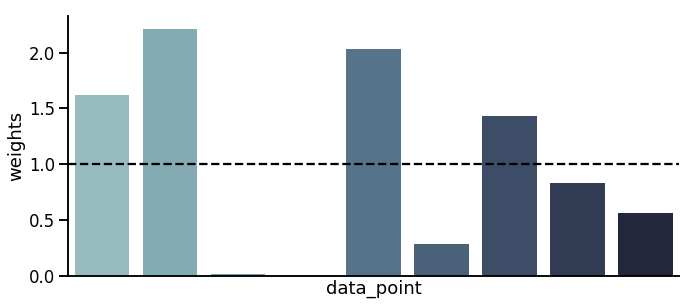

In [17]:
sns.set_context('talk')
g = plot_distance_weights(model, distance_fn)

In [18]:
print(distance_fn.w)

{0: {0: 1.623698334570911, 1: 2.2178029171387856, 2: 0.009717925486541391, 3: 0.006871611010598997, 4: 2.0326499488564727, 5: 0.28568015663160984, 6: 1.4304399002321044, 7: 0.8285076357699662, 8: 0.5646315703030105}}


In [19]:
g.savefig('results/extra/dist_weights.pdf')

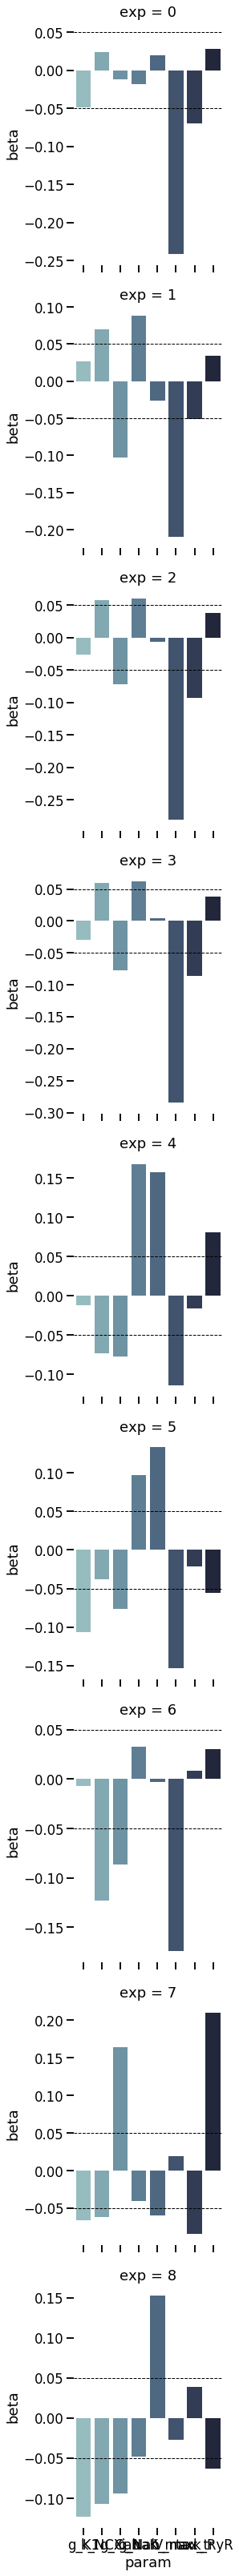

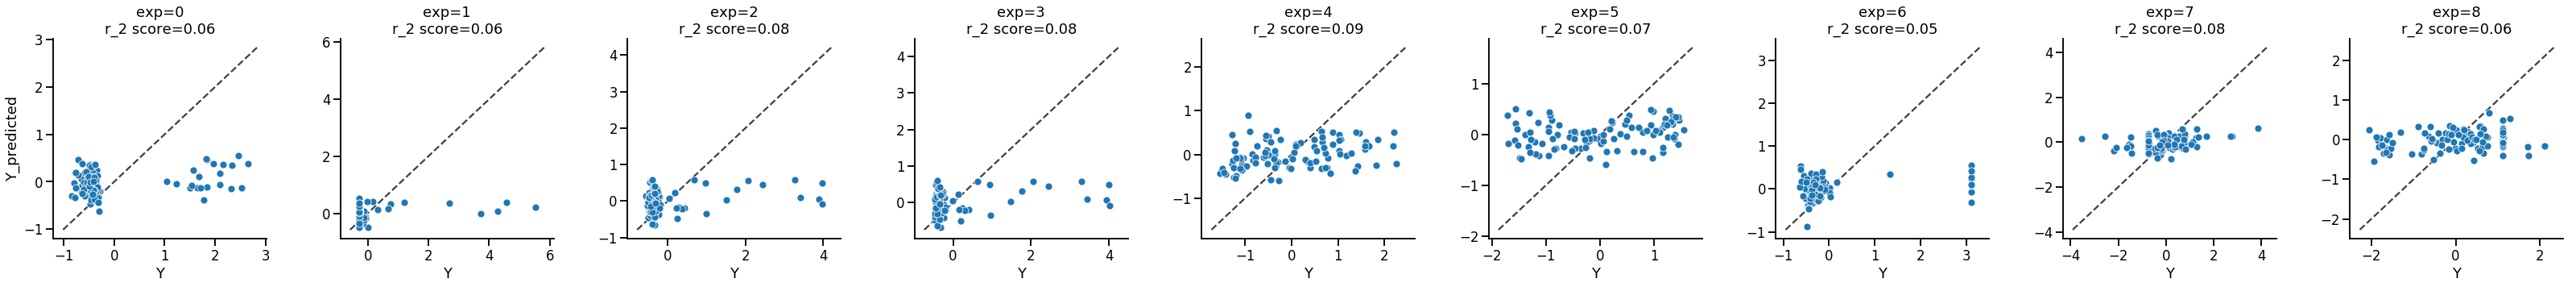

In [21]:
sns.set_context('talk')
grid1, grid2 = plot_parameter_sensitivity(
    model,
    parameters,
    distance_fn,
    sigma=0.1,
    n_samples=100,
    plot_cutoff=0.05)

In [22]:
grid1.savefig('results/extra/sensitivity.pdf')
grid2.savefig('results/extra/sensitivity_fit.pdf')

# Initialise database

In [18]:
db_path = ('sqlite:///' + 
           os.path.join(tempfile.gettempdir(), "hl-1_extra-all.db"))
print(db_path)

sqlite:////scratch/cph211/tmp/hl-1_extra-all.db


In [19]:
# Let's log all the sh!t
import logging
logging.basicConfig()
abc_logger = logging.getLogger('ABC')
abc_logger.setLevel(logging.DEBUG)
eps_logger = logging.getLogger('Epsilon')
eps_logger.setLevel(logging.DEBUG)
cv_logger = logging.getLogger('CV Estimation')
cv_logger.setLevel(logging.DEBUG)

In [20]:
from pyabc.sampler import SingleCoreSampler
from pyabc.populationstrategy import ConstantPopulationSize

In [20]:
abc = ABCSMC(models=model,
             parameter_priors=prior,
             distance_function=IonChannelDistance(
                 obs=obs,
                 exp_map=exp,
                 err_bars=errs,
                 err_th=0.01),
             #population_size=ConstantPopulationSize(20),
             population_size=AdaptivePopulationSize(
                 start_nr_particles=5000,
                 mean_cv=0.2,
                 max_population_size=5000,
                 min_population_size=100),
             summary_statistics=ion_channel_sum_stats_calculator,
             transitions=EfficientMultivariateNormalTransition(scaling=0.5),
             eps=MedianEpsilon(),
             sampler=MulticoreEvalParallelSampler(n_procs=12),
             #sampler=SingleCoreSampler(),
             acceptor=IonChannelAcceptor())

DEBUG:ABC:ion channel weights: {0: 1.7088818552370035, 1: 1.8673237918134478, 2: 0.004821409298446913, 3: 0.0073055383067307566, 4: 2.1392881557442713, 5: 0.3006676952699076, 6: 1.5054845709130198, 7: 0.8719733435378301, 8: 0.594253639879343}
DEBUG:Epsilon:init quantile_epsilon initial_epsilon=from_sample, quantile_multiplier=1


In [21]:
abc_id = abc.new(db_path, obs)

INFO:History:Start <ABCSMC(id=17, start_time=2018-10-14 17:05:11.457707, end_time=None)>
INFO:Epsilon:initial epsilon is 272.80433438979935


In [ ]:
history = abc.run(minimum_epsilon=0.01, max_nr_populations=5, min_acceptance_rate=0.001)

INFO:ABC:t:0 eps:272.80433438979935
DEBUG:ABC:now submitting population 0


In [ ]:
history = abc.run(minimum_epsilon=0.01, max_nr_populations=5, min_acceptance_rate=0.001)

In [ ]:
history = abc.run(minimum_epsilon=0.01, max_nr_populations=5, min_acceptance_rate=0.001)

In [ ]:
history = abc.run(minimum_epsilon=0.01, max_nr_populations=5, min_acceptance_rate=0.001)

# Results analysis

In [25]:
#db_path = 'sqlite:///results/extra/hl-1_extra.db'
db_path = 'sqlite:////scratch/cph211/tmp/hl-1_extra-all.db'
history = History(db_path)
history.all_runs()

[<ABCSMC(id=1, start_time=2018-10-10 14:04:57.427684, end_time=None)>,
 <ABCSMC(id=2, start_time=2018-10-10 14:09:38.254883, end_time=2018-10-10 15:08:34.065779)>,
 <ABCSMC(id=3, start_time=2018-10-10 17:19:32.614081, end_time=2018-10-11 03:23:14.264367)>,
 <ABCSMC(id=4, start_time=2018-10-11 09:57:27.780886, end_time=None)>,
 <ABCSMC(id=5, start_time=2018-10-11 10:02:08.870533, end_time=None)>,
 <ABCSMC(id=6, start_time=2018-10-11 10:03:52.846187, end_time=2018-10-11 10:05:58.809079)>,
 <ABCSMC(id=7, start_time=2018-10-11 10:06:53.875266, end_time=2018-10-11 10:09:09.793633)>,
 <ABCSMC(id=8, start_time=2018-10-11 10:09:20.291788, end_time=None)>,
 <ABCSMC(id=9, start_time=2018-10-11 11:07:13.103685, end_time=None)>,
 <ABCSMC(id=10, start_time=2018-10-11 13:39:41.600872, end_time=None)>,
 <ABCSMC(id=11, start_time=2018-10-11 13:42:05.631436, end_time=None)>,
 <ABCSMC(id=12, start_time=2018-10-11 14:04:48.165795, end_time=None)>,
 <ABCSMC(id=13, start_time=2018-10-11 14:04:53.516548, en

In [26]:
#history.id = 15 # run with err=0.1 and scaling=0.25
history.id = 17 # run with err=0.01 and scaling=0.5

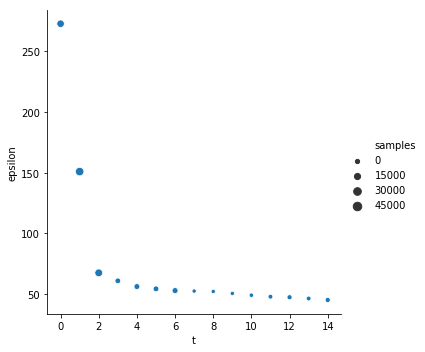

In [27]:
evolution = history.get_all_populations()
grid = sns.relplot(x='t', y='epsilon', size='samples', data=evolution[evolution.t>=0])
#grid.savefig('results/extra/eps_evolution.pdf')

In [28]:
df, w = history.get_distribution(m=0)

In [29]:
df_extra = df.loc[:,[k for k in limits.keys()]]

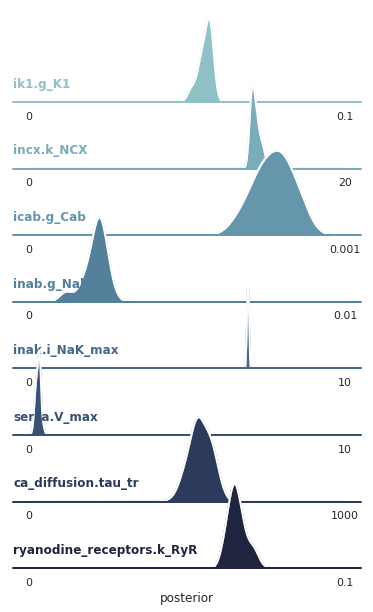

In [30]:
from ionchannelABC import plot_parameters_kde
g = plot_parameters_kde(df_extra, w, limits, aspect=5, height=1.1)

# Samples for quantitative analysis

In [31]:
# Generate parameter samples
n_samples = 100
df, w = history.get_distribution(m=0)
th_samples = df.sample(n=n_samples, weights=w, replace=True).to_dict(orient='records')

In [32]:
# Generate sim results samples
samples = pd.DataFrame({})
for i, th in enumerate(th_samples):
    output = model.sample(pars=th)
    output['sample'] = i
    output['distribution'] = 'post'
    samples = samples.append(output, ignore_index=True)

In [33]:
samples.head(18)

,x,y,exp,sample,distribution
0,vrp,-74.635565,0,0,post
1,ca_i,0.081123,0,0,post
2,k_i,125717.598152,0,0,post
3,na_i,12141.259942,0,0,post
4,apa,97.819459,0,0,post
5,apd90,51.602549,0,0,post
6,t_ca_rise,44.166423,0,0,post
7,t_ca50,146.778689,0,0,post
8,t_ca90,374.350052,0,0,post
9,vrp,-74.474283,0,1,post


# Evaluate results

In [34]:
import scipy.stats as st
def evaluate_samples(samples):
    for measurement in samples['x'].unique():
        filtered = samples[samples.x==measurement]['y'].tolist()
        rv = st.rv_discrete(values=(filtered, [1/len(filtered),]*len(filtered)))
        print("{}, median: {}".format(measurement, rv.median()))
        print("{}, 95% CI: {}".format(measurement, rv.interval(0.95)))

In [35]:
evaluate_samples(samples)

vrp, median: -74.66804516988311
vrp, 95% CI: (-75.38982651146182, -74.2334582241799)
ca_i, median: 0.0828362030177788
ca_i, 95% CI: (0.0757730102586334, 0.08566923831064321)
k_i, median: 125629.06271904684
k_i, 95% CI: (125390.31858933711, 125926.85337947492)
na_i, median: 12239.76755855152
na_i, 95% CI: (11996.292526050573, 12468.37366843813)
apa, median: 95.97851539818457
apa, 95% CI: (94.17081229334839, 100.11525837081551)
apd90, median: 48.442253216732446
apd90, 95% CI: (43.71346589866638, 58.054584807211846)
t_ca_rise, median: 43.51768710068427
t_ca_rise, 95% CI: (40.747978269297164, 47.76650478240723)
t_ca50, median: 154.23008477998277
t_ca50, 95% CI: (149.27140899074342, 160.8500110040574)
t_ca90, median: 381.3667707933346
t_ca90, 95% CI: (374.350051511991, 397.8803253844214)


## Test for specific modes of AP model

In [49]:
samp_pivot = samples.pivot(index='sample', columns='x', values='y')

In [50]:
from sklearn.cluster import AffinityPropagation

In [51]:
af = AffinityPropagation()

In [52]:
af.fit(samp_pivot.values)

AffinityPropagation(affinity='euclidean', convergence_iter=15, copy=True,
          damping=0.5, max_iter=200, preference=None, verbose=False)

In [53]:
centers = pd.DataFrame(af.cluster_centers_, columns=samp_pivot.columns)

In [55]:
af.cluster_centers_indices_

array([  32,   45,  334,  576,  618,  644,  769,  796,  938,  964, 1000,
       1056, 1062, 1122, 1130, 1182, 1238, 1244, 1258, 1263, 1276, 1289,
       1331, 1394, 1475, 1509, 1589, 1604, 1642, 1688, 1703, 1736, 1899,
       1905, 1965, 1971, 2006, 2068, 2082, 2102, 2134, 2137, 2141, 2220,
       2328, 2412, 2451, 2642, 2700, 2746, 2754, 2770, 2842, 2853, 2864,
       2925, 2963, 3027, 3028, 3029, 3083, 3093, 3242, 3264, 3377, 3385,
       3433, 3534, 3551, 3575, 3606, 3691, 3840, 3865, 3870, 4001, 4016,
       4043, 4115, 4121, 4248, 4282, 4351, 4360, 4406, 4410, 4431, 4595,
       4632, 4683, 4695, 4701, 4784])

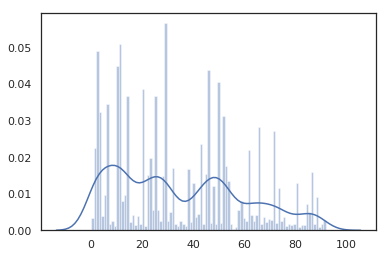

In [56]:
sns.distplot(af.labels_, bins=len(af.cluster_centers_))

## Plot sample of voltage traces

In [36]:
from ionchannelABC import (Experiment, ExperimentStimProtocol)

In [40]:
# Create new experiment to generate traces
pulses = range(5, 45, 5)
stim_times = [1000000] + [2, 4998]*len(pulses)
stim_levels = [0]
for level in pulses:
    stim_levels.append(level)
    stim_levels.append(0)
pace_time = np.linspace(0, 10000, 10000)
#pace_time = np.linspace(0, sum(stim_times[1:]), sum(stim_times[1:]))

def trace_measurements(data_list):
    import numpy as np
    data = data_list[0]
    if len(data_list) > 1:
        for log in data_list[1:]:
            data = data.extend(log)
    simtime = data['environment.time']
    simtime_min = min(simtime)
    simtime = [t - simtime_min for t in simtime]
    data_output = dict()
    data['environment.time'] = simtime
    for var in data:
        data_output[var] = np.interp(pace_time, simtime, data[var])
    return data_output
def unwrap(data, ind_var):
    return data[0], True

trace_prot = ExperimentStimProtocol(stim_times, stim_levels, 
                                    measure_index=range(len(stim_times)-4, len(stim_times)),
                                    measure_fn=trace_measurements,
                                    post_fn=unwrap)
dias_conditions = dict(T=305, Ca_o=1800, Na_o=1.4e5, K_o=4e3)
trace_exper = Experiment(trace_prot, None, dias_conditions)

In [41]:
model.add_experiments([trace_exper])

In [148]:
# Generate traces
traces = pd.DataFrame({})
for i, th in enumerate(th_samples):
    output = model.sample(pars=th,exp_num=1)
    output['sample'] = i
    traces = traces.append(output, ignore_index=True)

In [90]:
import pickle
with open('traces.pkl','wb') as f:
    pickle.dump(traces, f)

In [98]:
import pickle
with open('traces.pkl','rb') as f:
    traces = pickle.load(f)

In [149]:
traces.x.unique()

array(['membrane.V', 'ical.d', 'ical.f', 'ical.fCa', 'ina.m', 'ina.h',
       'ina.j', 'ito.xto', 'ito.yto', 'ikr.C_K1', 'ikr.C_K2', 'ikr.O_K',
       'ikr.I_K', 'ikur.a_ur', 'ikur.i_ur', 'icat.b', 'icat.g', 'iha.y',
       'ryanodine_receptors.P_open', 'ca_conc_sr.Ca_SRuptake',
       'ca_conc_sr.Ca_SRrelease', 'ca_conc.Ca_i', 'na_conc.Na_i',
       'k_conc.K_i', 'environment.time', 'ina.E_Na', 'ina.G_Na',
       'ina.i_Na', 'ina.m_ss', 'ina.tau_m', 'ina.h_ss', 'ina.tau_h_high',
       'ina.tau_h_low', 'ina.tau_h', 'ina.j_ss', 'ina.tau_j_high',
       'ina.tau_j_low', 'ina.tau_j', 'ikr.G_Kr', 'ikr.E_Kr', 'ikr.i_Kr',
       'ikr.alpha_a0', 'ikr.alpha_a1', 'ikr.alpha_i', 'ikr.beta_a0',
       'ikr.beta_a1', 'ikr.beta_i', 'ikr.C_K0', 'ikur.G_Kur',
       'ikur.i_Kur', 'ikur.a_ur_ss', 'ikur.tau_a_ur', 'ikur.i_ur_ss',
       'ikur.tau_i_ur', 'ito.G_to', 'ito.i_to', 'ito.xto_ss',
       'ito.tau_xto', 'ito.yto_ss', 'ito.tau_yto', 'iha.G_ha',
       'iha.i_haNa', 'iha.i_haK', 'iha.i_ha', 'ih

In [150]:
time = traces[traces.x=='environment.time'].y.tolist()[0]

In [151]:
time

array([0.00000000e+00, 1.00010001e+00, 2.00020002e+00, ...,
       9.99799980e+03, 9.99899990e+03, 1.00000000e+04])

In [152]:
plotlims = (4950, 5400)

In [153]:
idxlims = np.intersect1d(np.where(time >= plotlims[0]), np.where(time <= plotlims[1]))

In [190]:
time_limited = time[idxlims[0]:idxlims[-1]]

In [155]:
traces = traces.set_index(['x','sample'])

In [156]:
del traces['exp']

In [157]:
traces.reset_index(inplace=True)

In [191]:
rows = []

In [192]:
_ = traces.apply(lambda row: [rows.append([row['x'], row['sample'], yi, ti])
                              for (ti, yi) in zip(time_limited, row.y[idxlims[0]:idxlims[-1]])], axis=1)

In [193]:
traces_new = pd.DataFrame(rows, columns=['x', 'sample', 'y', 'time']).set_index(['x', 'sample'])

In [194]:
traces_new.reset_index(inplace=True)

In [68]:
val = pd.DataFrame(traces[traces.x=='ca_conc.Ca_i'].y.tolist())

In [70]:
plotdata = val[9:10].melt()

(4950, 5400)

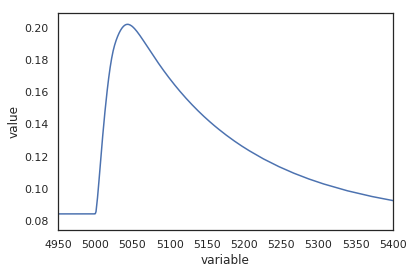

In [62]:
sns.lineplot(x='variable',y='value',data=plotdata,estimator=None)
plt.xlim(4950,5400)

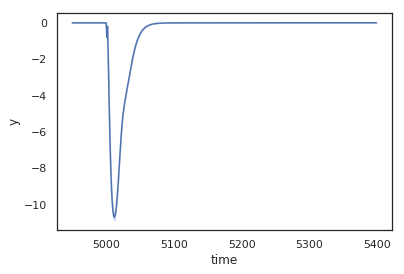

In [219]:
#sns.lineplot(x='variable',y='value',data=val.melt())
sns.lineplot(x='time',y='y',data=traces_new[traces_new.x=='icat.i_CaT'])

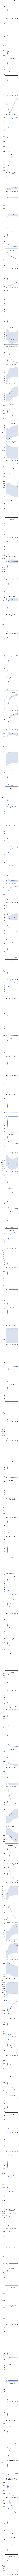

In [225]:
grid = sns.relplot(x='time', y='y', data=traces_new, row='x',
                   estimator=np.median, ci=95, kind='line',
                   facet_kws={'sharex': 'row',
                              'sharey': False})